## implementation stollen from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def truth_func(x, y):
    #return np.logical_xor(x, y)
    return x*y
    #return np.logical_or(x, y)
    #return np.logical_not(x)

def gen_xor_training(N):
    data   = np.random.randint(0, 2, (N, 2))
    target = truth_func(data[:, 0:1], data[:, 1:2])
    return data,target

def xor_to_flat(data, target):
    concat = np.concatenate((data, target), axis=1).astype(np.single) #.flatten()
    #concat = 2*concat - 1
    return concat

def flat_to_xor(data):
    #data = data.reshape(-1, 3)
    #data = (data + 1)/2
    return data[:, 0:2], data[:, 2:3]

def xor_sucess_rate(data, target):
    ground_truth = truth_func(data[:, 0:1], data[:, 1:2])
    return 1 - np.mean(np.abs(target - ground_truth))

In [3]:
# this is a descrete RBM
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h      = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
       
        return sample_h
    
   def h_to_v(self,h):
        p_v      = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
       
        return sample_v,p_v

   def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            v_,p_v = self.h_to_v(h_)
            h_     = self.v_to_h(v_)
        
        return v,v_,p_v

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

# Out of equilibrium

In [6]:
batch_size = 100
n_it_train = 4
rbm_small = RBM(3, 3, k=n_it_train)
train_op = optim.SGD(rbm_small.parameters(), 0.1)

losses = []
sucess_rates = []

for epoch in range(15):
    loss_ = []
    sucess_rate_ = []
    for i in range(1000):
        data,target = gen_xor_training(batch_size)
        data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.single)))
        
        v,v1,p_v1 = rbm_small(data_var)
        loss = rbm_small.free_energy(v) - rbm_small.free_energy(v1)
        #loss = torch.abs(v - v1).mean()
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        sucess_rate = xor_sucess_rate(*flat_to_xor(v1.detach().numpy()))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm_small.v_bias.detach().numpy())
print("h_bias:", rbm_small.h_bias.detach().numpy())
print("W:\n", rbm_small.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.03671431168913841, 64%
Training loss and sucess rate for 1 epoch: -0.09362553060054779, 71%
Training loss and sucess rate for 2 epoch: -0.10001570731401443, 77%
Training loss and sucess rate for 3 epoch: -0.09327195584774017, 82%
Training loss and sucess rate for 4 epoch: -0.11371072381734848, 85%
Training loss and sucess rate for 5 epoch: -0.15773150324821472, 90%
Training loss and sucess rate for 6 epoch: -0.13866686820983887, 94%
Training loss and sucess rate for 7 epoch: -0.11740243434906006, 95%
Training loss and sucess rate for 8 epoch: -0.10223942250013351, 96%
Training loss and sucess rate for 9 epoch: -0.09181755036115646, 97%
Training loss and sucess rate for 10 epoch: -0.08199523389339447, 97%
Training loss and sucess rate for 11 epoch: -0.07361502200365067, 97%
Training loss and sucess rate for 12 epoch: -0.06669904291629791, 98%
Training loss and sucess rate for 13 epoch: -0.0619155690073967, 98%
Training loss and sucess rate f

In [21]:
W_eigen_vect  = np.linalg.svd(rbm_small.W.detach().numpy()).Vh.T
W_eigen_vect /= np.abs(W_eigen_vect).sum(1)

data     = xor_to_flat(*gen_xor_training(1000))
_,_,data = rbm_small(torch.from_numpy(data))
data     = data.detach().numpy()

pca = PCA(3)
pca.fit(data)
pc_data  = np.linalg.eig(pca.get_covariance()).eigenvectors
pc_data /= np.abs(pc_data).sum(1)

corr_mat = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        corr_mat[i, j] = abs(W_eigen_vect[i, :].dot(pc_data[j, :]))

for i in range(3):
    idx = np.argmax(corr_mat[i, i:]) + i
    save             = np.copy(corr_mat[idx, :])
    corr_mat[idx, :] =         corr_mat[i,   :]
    corr_mat[i,   :] = save

print(corr_mat.T)

[[0.36405212 0.10662834 0.0866928 ]
 [0.09584596 0.38108122 0.01251316]
 [0.14767002 0.11051006 0.36703193]]


In [28]:
data,target = gen_xor_training(100)
data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.single)))


n_it = 2*n_it_train

prob_traj_noFlip = np.zeros((n_it+1, 100))
prob_traj_noFlip[0, :] = np.ones(prob_traj_noFlip.shape[1])

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_noFlip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_noFlip[i+1, ground_truth==0] = 1-prob_traj_noFlip[i+1, ground_truth==0]


data_var[:, 2] = 1 - data_var[:, 2]
prob_traj_flip = np.zeros((n_it+1, 100))

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_flip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_flip[i+1, ground_truth==0] = 1-prob_traj_flip[i+1, ground_truth==0]

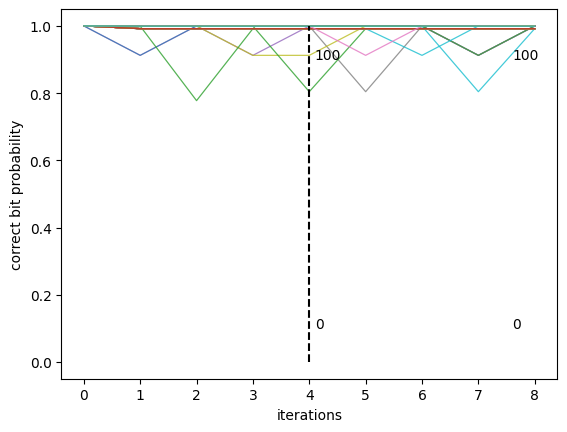

In [29]:
plt.plot(prob_traj_noFlip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train, n_it_train], [0, 1], "k--")

n_true  = sum(prob_traj_noFlip[n_it_train, :] > 0.5)
n_false = prob_traj_noFlip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_noFlip[-1, :] > 0.5)
n_false_end = prob_traj_noFlip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_stability.png')

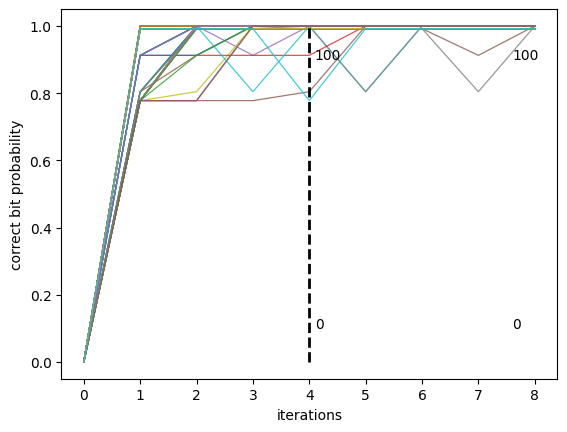

In [30]:
plt.plot(prob_traj_flip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train, n_it_train], [0, 1], "k--", linewidth=2)

n_true = sum(prob_traj_flip[n_it_train, :] > 0.5)
n_false = prob_traj_flip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_flip[-1, :] > 0.5)
n_false_end = prob_traj_flip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_correction.png')

# At equilibrium

In [32]:
batch_size = 100
n_it_train = 30
rbm_big = RBM(3, 3, k=n_it_train)
train_op = optim.SGD(rbm_big.parameters(), 0.1)

losses = []
sucess_rates = []

for epoch in range(15):
    loss_ = []
    sucess_rate_ = []
    for i in range(500):
        data,target = gen_xor_training(batch_size)
        data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.single)))
        
        v,v1,p_v1 = rbm_big(data_var)
        loss = rbm_big.free_energy(v) - rbm_big.free_energy(v1)
        #loss = torch.abs(v - v1).mean()
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        sucess_rate = xor_sucess_rate(*flat_to_xor(v1.detach().numpy()))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm_big.v_bias.detach().numpy())
print("h_bias:", rbm_big.h_bias.detach().numpy())
print("W:\n", rbm_big.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.014408653602004051, 62%
Training loss and sucess rate for 1 epoch: -0.057177670300006866, 65%
Training loss and sucess rate for 2 epoch: -0.08880443871021271, 69%
Training loss and sucess rate for 3 epoch: -0.10132048279047012, 73%
Training loss and sucess rate for 4 epoch: -0.10286146402359009, 76%
Training loss and sucess rate for 5 epoch: -0.09824467450380325, 79%
Training loss and sucess rate for 6 epoch: -0.09130167961120605, 81%
Training loss and sucess rate for 7 epoch: -0.09205219149589539, 82%
Training loss and sucess rate for 8 epoch: -0.09506688266992569, 84%
Training loss and sucess rate for 9 epoch: -0.11887157708406448, 86%
Training loss and sucess rate for 10 epoch: -0.15175148844718933, 89%
Training loss and sucess rate for 11 epoch: -0.15602968633174896, 91%
Training loss and sucess rate for 12 epoch: -0.14545658230781555, 93%
Training loss and sucess rate for 13 epoch: -0.12848331034183502, 94%
Training loss and sucess rat

In [33]:
W_eigen_vect  = np.linalg.svd(rbm_small.W.detach().numpy()).Vh.T
W_eigen_vect /= np.abs(W_eigen_vect).sum(1)

data     = xor_to_flat(*gen_xor_training(1000))
_,_,data = rbm_small(torch.from_numpy(data))
data     = data.detach().numpy()

pca = PCA(3)
pca.fit(data)
pc_data  = np.linalg.eig(pca.get_covariance()).eigenvectors
pc_data /= np.abs(pc_data).sum(1)

corr_mat = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        corr_mat[i, j] = abs(W_eigen_vect[i, :].dot(pc_data[j, :]))

for i in range(3):
    idx = np.argmax(corr_mat[i, i:]) + i
    save             = np.copy(corr_mat[idx, :])
    corr_mat[idx, :] =         corr_mat[i,   :]
    corr_mat[i,   :] = save

print(corr_mat.T)

[[0.30556473 0.11021081 0.23904997]
 [0.20056693 0.3348991  0.07497269]
 [0.07357244 0.20927948 0.32832888]]


In [34]:
data,target = gen_xor_training(100)
data_var = Variable(torch.from_numpy(xor_to_flat(data, target).astype(np.single)))


n_it = 2*n_it_train

prob_traj_noFlip = np.zeros((n_it+1, 100))
prob_traj_noFlip[0, :] = np.ones(prob_traj_noFlip.shape[1])

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_noFlip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_noFlip[i+1, ground_truth==0] = 1-prob_traj_noFlip[i+1, ground_truth==0]


data_var[:, 2] = 1 - data_var[:, 2]
prob_traj_flip = np.zeros((n_it+1, 100))

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_flip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_flip[i+1, ground_truth==0] = 1-prob_traj_flip[i+1, ground_truth==0]

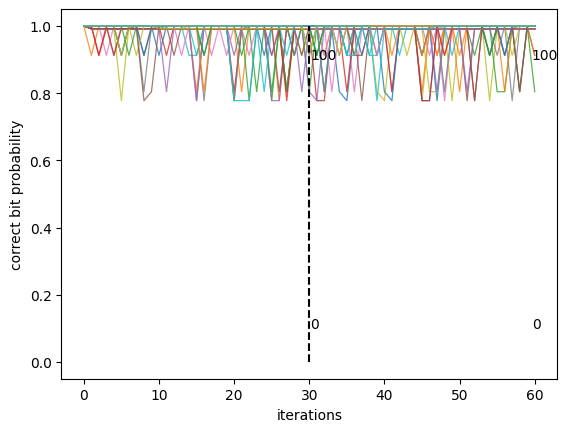

In [35]:
plt.plot(prob_traj_noFlip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train, n_it_train], [0, 1], "k--")

n_true  = sum(prob_traj_noFlip[n_it_train, :] > 0.5)
n_false = prob_traj_noFlip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_noFlip[-1, :] > 0.5)
n_false_end = prob_traj_noFlip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_stability.png')

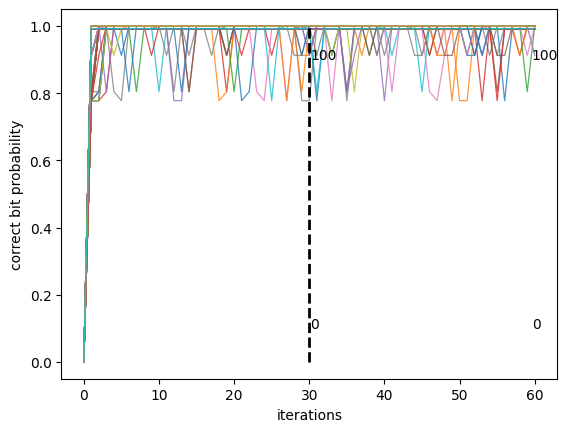

In [36]:
plt.plot(prob_traj_flip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train, n_it_train], [0, 1], "k--", linewidth=2)

n_true = sum(prob_traj_flip[n_it_train, :] > 0.5)
n_false = prob_traj_flip.shape[1] - n_true

plt.text(n_it_train+0.1, 0.9, f"{n_true }")
plt.text(n_it_train+0.1, 0.1, f"{n_false}")

n_true_end  = sum(prob_traj_flip[-1, :] > 0.5)
n_false_end = prob_traj_flip.shape[1] - n_true_end

plt.text(n_it-0.4, 0.9, f"{n_true_end }")
plt.text(n_it-0.4, 0.1, f"{n_false_end}")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_correction_lo.png')